In [1]:
from datetime import datetime, timedelta

# pandas and plotting libraries for visualizations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# module containing functions for manipulation pyspark dataframes
import pyspark.sql.functions as f
import pyspark.sql.types as t
from pyspark.sql.window import Window
from pyspark.sql import DataFrame

# class which will let us create spark objects
from pyspark.sql import SparkSession

# modelling
from pyspark.ml.feature import Imputer, VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# helper functions for the class
from helpers import display, read_df, write_df, feature_importances

## [PySpark ML docs](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html)

## Create a Spark Session

In [ ]:
spark = (
    SparkSession
    .builder
    .appName('model')
    .master('local[2]')
    .getOrCreate()
)

## Build Pipeline

In [ ]:
features = read_df(spark, 'features')

In [ ]:
# check for nulls
display(features.agg(*[f.sum(f.col(c).isNull().cast(t.IntegerType())).alias(c) for c in features.columns]))

In [5]:
numeric_cols = [c for c in features.columns if c != 'trip_id' and c != 'label' and c != 'company']
imputed_numeric_cols = [c + '_imp' for c in numeric_cols]

In [6]:
features = features.select('trip_id', 'company', *[f.col(c).cast(t.DoubleType()) for c in numeric_cols], 'label')
features = features.fillna('no_company')

In [7]:
train, test = features.randomSplit([0.7, 0.3])

In [8]:
pipeline = Pipeline(stages=[
    StringIndexer(inputCol='company', outputCol='company_ind'),
    Imputer(inputCols=numeric_cols, outputCols=imputed_numeric_cols),
    VectorAssembler(inputCols=imputed_numeric_cols + ['company_ind'], outputCol='features'),
    RandomForestRegressor(maxBins=60),
])

In [10]:
train.cache()

DataFrame[trip_id: string, company: string, census_tract: double, month: double, year: double, day_of_week: double, hour: double, trip_total: double, trip_seconds: double, trip_miles: double, avg_miles: double, label: double]

In [11]:
model = pipeline.fit(train)

In [12]:
train_predictions = model.transform(train)
predictions = model.transform(test)

## Evaluate

In [24]:
evaluator = RegressionEvaluator(
    labelCol='label',
    predictionCol='prediction',
    metricName='rmse'
)
rmse = evaluator.evaluate(predictions)

In [25]:
print('RMSE on test data = {}'.format(rmse))

RMSE on test data = 1.934744791198814


In [ ]:
print('Most important features:')
feature_importances(predictions, model.stages[3])

In [27]:
to_plot = (
    predictions
    .select('prediction', 'label')
    .sample(withReplacement=False, fraction=.01)
    .toPandas()
)

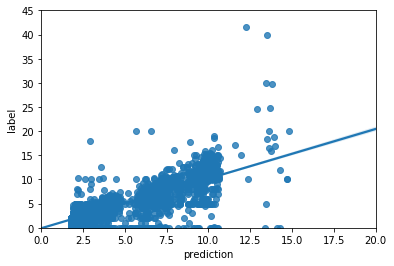

In [38]:
plt.figure()
plt.ylim(0, 45)
plt.xlim(0, 20)

sns.regplot(to_plot['prediction'], to_plot['label'])

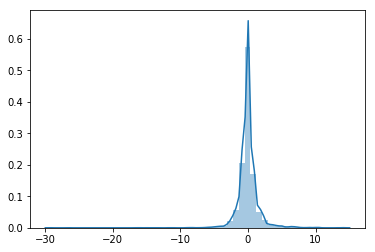

In [29]:
plt.figure()
sns.distplot(to_plot['prediction'] - to_plot['label'])